# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from scipy.stats import uniform as sp_rand
from sklearn.naive_bayes import  MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

c:\users\arya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [11]:
final['Time'] =pd.to_datetime(final.Time)

In [12]:
fin= final['Score']

In [13]:
fin.shape

(364171,)

In [14]:

stops = stopwords.words('english')
operators = set(('and', 'or', 'not'))
stop = set(stops) - operators

In [15]:

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [16]:
# this code takes a while to run as it needs to run on sentences.
str1=' '
final_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words)
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = " ".join(filtered_sentence) #final string of cleaned word
    final_string.append(str1)
  

In [17]:
x_train = final_string[0:200000]
x_test= final_string[200000:364171]
y_train=fin[0:200000]
y_test=fin[200000 :364171]

# Bag of Words (BoW)

In [20]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
x_traincv = count_vect.fit_transform(x_train)


In [21]:
#we considered voculbary as train data and  test data vectors are formed from train data words
x_testcv =count_vect.transform(x_test)

In [22]:
type(x_traincv)

scipy.sparse.csr.csr_matrix

In [23]:
x_traincv.get_shape()

(200000, 76836)

# TF-IDF

In [25]:
x_train1 = final_string[0:100000]
x_test1= final_string[250000:364171]
y_train1=fin[0:100000]
y_test1=fin[250000 :364171]

In [26]:
tf_idf_vect = TfidfVectorizer()
x_traintf= tf_idf_vect.fit_transform(x_train1)

In [27]:
x_traintf.get_shape()

(100000, 55413)

In [28]:
x_testtf=tf_idf_vect.transform(x_test1)

In [29]:
x_testtf.shape

(114171, 55413)

In [24]:
mnb =  MultinomialNB()
#paramet= np.array([0,1,0.1,0.01,0.0001,0.000001,0.2])
parameters = {'alpha': sp_rand()}
#parameters=dict(alpha=paramet)
#clf = GridSearchCV(estimator=mnb, param_grid=parameters)
clf=RandomizedSearchCV(estimator=mnb, param_distributions=parameters)
clf.fit(x_traincv,y_train)
print(clf.best_score_)
print(clf.best_estimator_.alpha)

0.90282
0.8207698826120005


In [25]:
#we used all accuracy models
mnb =  MultinomialNB(alpha=0.8207698826120005).fit(x_traincv,y_train)
y_predit = mnb.predict(x_testcv)
acc=accuracy_score(y_test,y_predit)
tr=mnb.score(x_traincv,y_train)
print("training_score",tr)
print("accuracy_score",acc)
#showing good accuracy means model is predicting well.
#confusion matrix,we can find true positive , false positive, true negtive and false negative 
confusion_matrix(y_test, y_predit)

training_score 0.91995
accuracy_score 0.903247223931145


array([[ 18519,   8587],
       [  7297, 129768]], dtype=int64)

In [35]:

ss=SGDClassifier(loss='hinge',alpha=0.0113357884218529,class_weight ="balanced")  # loss=hinge means we are implementing linear svm only
ss.fit(x_traincv,y_train)                                                        #alpha value from cross validation
y_predit = ss.predict(x_testcv)
tr=ss.score(x_traincv,y_train)
acc=accuracy_score(y_test,y_predit)
print("training score",tr)
print("accuracy_score",acc)
confusion_matrix(y_test, y_predit)

c:\users\arya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


training score 0.87515
accuracy_score 0.8598168982341583


array([[ 23483,   3623],
       [ 19391, 117674]], dtype=int64)

In [36]:
#we are calculated hyperparameter "c" using the both grid search and random search 
clf = DecisionTreeClassifier()
#parameters= {'alpha': sp_rand()}
parameters = {'max_depth':[3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,40,50]}
clf = GridSearchCV(estimator=clf, param_grid=parameters)
#clf=RandomizedSearchCV(estimator=ss, param_distributions=parameters)
clf.fit(x_traincv,y_train)
print(clf.best_estimator_)
print(clf.best_params_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
{'max_depth': 20}


In [37]:
clf = DecisionTreeClassifier(max_depth = 20)
clf.fit(x_traincv,y_train)
y_predit = clf.predict(x_testcv)
tr=clf.score(x_traincv,y_train)
acc=accuracy_score(y_test,y_predit)
confusion_matrix(y_test, y_predit)
print("training score",tr)
print("accuracy_score",acc)

training score 0.89814
accuracy_score 0.8600300905762893


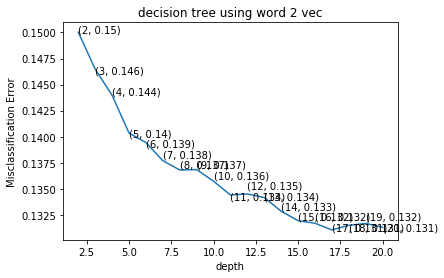

In [38]:
cv_scores = []
l=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# perform 10-fold cross validation
for k in l:
    clf = DecisionTreeClassifier(max_depth = k)
    scores = cross_val_score(clf, x_traincv, y_train, cv=2, scoring='accuracy')
    cv_scores.append(scores.mean())
m=[]
for i in cv_scores:
    l=1-i
    m.append(l)
k=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

plt.plot(k,m)
for xy in zip(k, np.round(m,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.title('decision tree using word 2 vec')
plt.xlabel('depth')
plt.ylabel('Misclassification Error')
plt.show()

In [39]:
cl =RandomForestClassifier(n_estimators=30)# we have got estimartors using cross validation
cl.fit(x_traincv,y_train)
y_predit = cl.predict(x_testcv)
tr=cl.score(x_traincv,y_train)
acc=accuracy_score(y_test,y_predit)
print("training score",tr)
print("accuracy_score",acc)
confusion_matrix(y_test, y_predit)

training score 0.99961
accuracy_score 0.8751911117066961


array([[  7247,  19859],
       [   631, 136434]], dtype=int64)

In [31]:
import numpy as np
from scipy.stats import uniform as sp_rand
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
log= LogisticRegression(n_jobs = 5)
#parameters= {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}
parameters = {'C': sp_rand()}
#clf = GridSearchCV(estimator=log, param_grid=parameters)
clf=RandomizedSearchCV(estimator=log, param_distributions=parameters)
clf.fit(x_traintf,y_train1)
print(clf.best_estimator_)

c:\users\arya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
c:\users\arya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
c:\users\arya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_jobs))
c:\users\arya\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(self.n_job

LogisticRegression(C=0.978978958349702, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=5, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [33]:
log= LogisticRegression(C=0.978978958349702)
log.fit(x_traintf,y_train1)
y_predit = log.predict(x_testtf)
tr=log.score(x_traintf,y_train1)
acc=accuracy_score(y_test1,y_predit)
print("training score",tr)
print("accuracy_score",acc)
confusion_matrix(y_test1, y_predit)

training score 0.93809
accuracy_score 0.9187008960243844


array([[11798,  7387],
       [ 1895, 93091]], dtype=int64)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
clf =rc = GradientBoostingClassifier(n_estimators=80,learning_rate= 0.4,max_depth=5)
clf.fit(x_traintf,y_train1)
y_predit = clf.predict(x_testtf)
tr=clf.score(x_traintf,y_train1)
acc=accuracy_score(y_test1,y_predit)
print("training score",tr)
print("accuracy_score",acc)
confusion_matrix(y_test1, y_predit)

training score 0.9324
accuracy_score 0.8952098168536669


array([[ 9487,  9698],
       [ 2266, 92720]], dtype=int64)

In [1]:
from IPython.display import HTML
s = """<table>
<tr>
<th>algorithm</th>
<th>training accuracy</th>
<th>testaccuracy</th>
</tr>
<tr>
<td>multinomial naive bayes</td>
<td>0.91995  </td>
<td>0.903247223931145</td>
</tr>
<tr>
<td>logistic with balanced</td>
<td>0.93809</td>
<td>0.9187008960243844</td>
</tr>
<tr>
<td>svm</td>
<td>0.87515</td>
<td>0.8598168982341583</td>
</tr>
<tr>
<td>deciion tree</td>
<td>0.89814</td>
<td>0.8600300905762893</td>
</tr>
<tr>
<td>Random forest</td>
<td>0.99961</td>
<td>0.8751911117066961</td>
</tr>
<tr>
<td>gradient bosting</td>
<td>0.9324</td>
<td>0.8952098168536669</td>
</tr>

</table>"""

In [2]:
print("Amazon Fine Food Reviews Analysis")
h = HTML(s)
display(h)

Amazon Fine Food Reviews Analysis


algorithm,training accuracy,testaccuracy
multinomial naive bayes,0.91995,0.903247223931145
logistic with balanced,0.93809,0.9187008960243844
svm,0.87515,0.8598168982341583
deciion tree,0.89814,0.8600300905762893
Random forest,0.99961,0.8751911117066961
gradient bosting,0.9324,0.8952098168536669
